In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score as NMI

from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from scipy.stats import t, f_oneway

import sys
sys.path.insert(1, "../utilities")
from MF import *
from plot_utils import *

import pystan

In [2]:
def dof_estimate(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = x1.var(ddof=1)/n1, x2.var(ddof=1)/n2

    return (s1 + s2)**2 / (s1**2/(n1-1) + s2**2/(n2-1))
    
def t_stat(x1,x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    s1, s2 = x1.var(ddof=1)/n1, x2.var(ddof=1)/n2
    
    return (m1 - m2) / np.sqrt(s1 + s2)

def t_test_(x1, x2):
    # p-value for 2-sided test
    tstat = t_stat(x1, x2)
    dof = dof_estimate(x1,x2)
    
    return 2*(1 - t.cdf(abs(tstat), dof)), tstat, dof


def t_test(X1, X2):
    assert(np.all(X1.shape==X2.shape))
    n_tests = X1.shape[1]
    pvalues = np.zeros((n_tests,))
    tstats = np.zeros((n_tests,))
    dofs = np.zeros((n_tests,))
    
    for i in range(n_tests):
        p, ts, d = t_test_(X1[:,i], X2[:,i])
        pvalues[i] = p
        tstats[i] = ts
        dofs[i] = d
        
    return pvalues, tstats, dofs


def get_IDs(S):
    ids=np.empty((len(S),), dtype=object)
    
    for i in range(len(S)):
        ids[i]=S.iloc[i].split('_')[-1].split('.')[0]
    
    return ids

In [3]:
path = '../../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/'
filenames = [line.rstrip() for line in open(path +'filenames.txt')]
filenames

['cellsRPnegGFstatus.csv',
 'cellsRPposGFstatus.csv',
 'cellshilicnegGFstatus.csv',
 'cellshilicposGFstatus.csv',
 'cellslipidnegGFstatus.csv',
 'cellslipidposGFstatus.csv',
 'mediumRPnegGFstatus.csv',
 'mediumRPposGFstatus.csv',
 'mediumhilicnegGFstatus.csv',
 'mediumhilicposGFstatus.csv']

In [5]:
filenum = 0
file = filenames[filenum]
df=pd.read_csv(path+file, sep=';', header=None)
tle=file
tle

'cellsRPnegGFstatus.csv'

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aSYN,aSYN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],MS2,Reference Ion,Area: 220929_SarkaLehtonen_RP_neg_0088.raw (F15),Area: 220929_SarkaLehtonen_RP_neg_0092.raw (F19),...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...,Gap Fill Status: 220929_SarkaLehtonen_RP_neg_0...
3,"1-(2,3,5-Trihydroxy-4-methylphenyl)-1-decanone",C17 H26 O4,2.11,294.18373,293.17645,8.327,DDA for preferred ion,[M-H]-1,24.227540350491672,23.73037326409131,...,0,0,0,0,0,0,0,0,0,0
4,CAPROYL SARCOSINE,C13 H25 N O3,1.22,243.18374,242.17646,7.697,DDA for preferred ion,[M-H]-1,20.925615823329725,20.24277556833173,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_X = df.iloc[3:,:48]
data_GAP = df.iloc[3:,88:]

groups = df.iloc[0,8:48]
labels = LabelEncoder().fit_transform(groups)

## M_eff estimation using HAC with correlation-distance

In [8]:
X=data_X.iloc[:,8:].T

# Correlation matrix with ddof=0 (just holding a fixed rule)
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(X)
cov_mat =np.cov(X_std.T)
COR = np.cov(X_std.T, ddof=0)

CD = 1 - COR
# make sure the diagonal is zero and the matrix is PD
CD = np.maximum(CD, CD.T)
CD -= np.diag(CD.diagonal())
CD=np.clip(CD,0,2)
cd_matrix = squareform(CD,force='tovector')

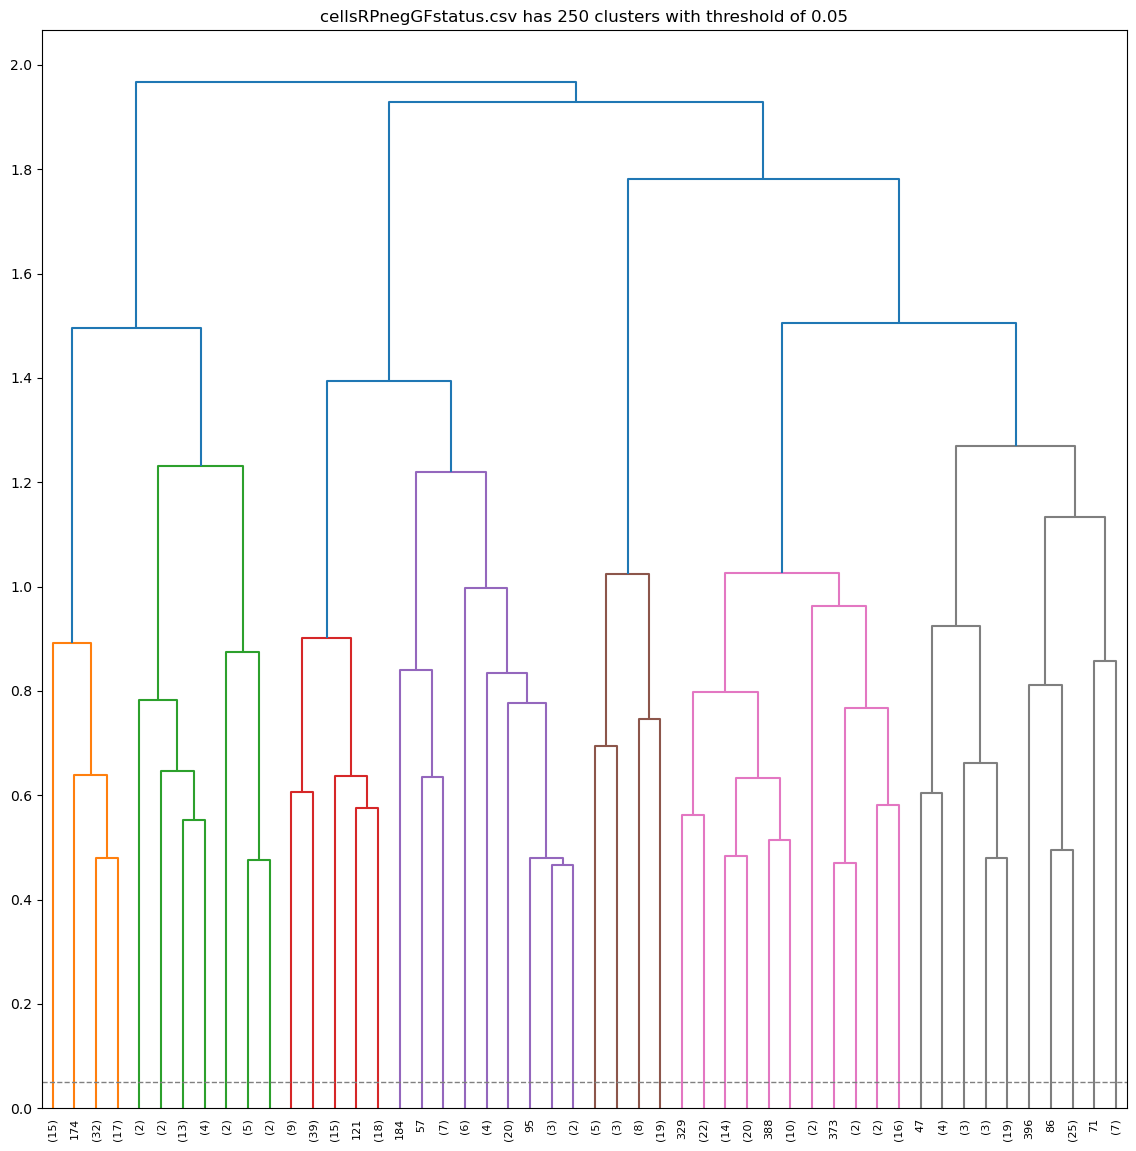

In [9]:
th=0.05
plt.figure(figsize=(14,14))
link_complete = hierarchy.linkage(cd_matrix, method='complete',  optimal_ordering=False)
labels_complete=hierarchy.fcluster(link_complete, t=th, criterion='distance')
hierarchy.dendrogram(link_complete, truncate_mode='lastp', p=50, labels=np.asarray(np.arange(CD.shape[0])))
plt.axhline(y=th, c='grey', lw=1, linestyle='dashed')
plt.yticks(np.arange(0,2.1,0.2))
plt.title("{} has {} clusters with threshold of {}".format(tle, np.unique(labels_complete).shape[0], th))
plt.show()

In [10]:
M_eff_HAC = np.unique(labels_complete).shape[0]
M_eff_HAC

250

In [11]:
print("Sidak alpha: \n%E" %  (1-(1-0.05)**(1/M_eff_HAC)))

Sidak alpha: 
2.051521E-04


## M_eff estimation technique 1

**Adjusting multiple testing in multilocus analyses using the eigenvalues of a correlation matrix**

https://www.nature.com/articles/6800717

$f(X) = I(x\geq0)  + (x - floor(x)), x>0$

In [12]:
f = lambda x: int(x>=1) + x - np.floor(x)

In [13]:
λ = np.real(np.linalg.eig(COR)[0])

In [14]:
M_eff1 = np.sum([f(elem) for elem in λ])
M_eff1

231.00000000000045

In [15]:
print("Sidak alpha: \n%E" %  (1-(1-0.05)**(1/M_eff1)))

Sidak alpha: 
2.220242E-04


In [16]:
print("Bonferroni alpha:\n%E" % (0.05/data_X.shape[0]))

Bonferroni alpha:
1.210654E-04


## M_eff estimation technique 2

**Cheverud (2001)**

$V(\lambda) = \sum_{i=1}^{M}(\lambda_i - 1)^2/(M-1)$

In [17]:
V = lambda λ: 1/(len(λ)-1)*(λ-1)@(λ-1)

In [18]:
M_eff2 = 1 + (len(λ)-1)*(1-V(λ)/len(λ))
M_eff2

320.3043301835446

In [19]:
print("Sidak alpha: \n%E" %  (1-(1-0.05)**(1/M_eff2)))

Sidak alpha: 
1.601264E-04


## HAC with correlation-distance

In [23]:
inds=np.argsort(labels_complete)
result = data_X.iloc[inds,:]
result_GAP = data_GAP.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=labels_complete[inds])
luniq=np.unique(labels_complete[inds])

In [27]:
k=luniq[2]

cluster_ind = np.where(labels_complete[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T
cluster_GAP = result_GAP.iloc[cluster_ind,:].to_numpy(dtype=int).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)
print("GAPS:",np.sum(cluster_GAP==32).sum())

[6.193 6.667]
GAPS: 0


In [28]:
cluster_GAP.shape

(40, 2)

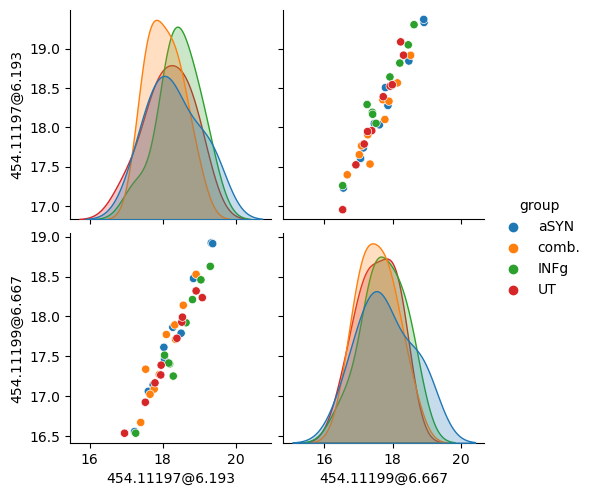

In [29]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

In [30]:
X_test = cluster

In [31]:
rank=1
U_init, V_init = nnd_svd_initialization(X_test, rank)

In [32]:
U, Vt = matrix_factorization(X_test, U_init, V_init, rank, alpha=0.002, beta = 0.02)

Number of steps: 5000


In [33]:
cluster_test = U@Vt.T
cluster_test[np.where(cluster_GAP!=32)] = cluster[np.where(cluster_GAP!=32)]

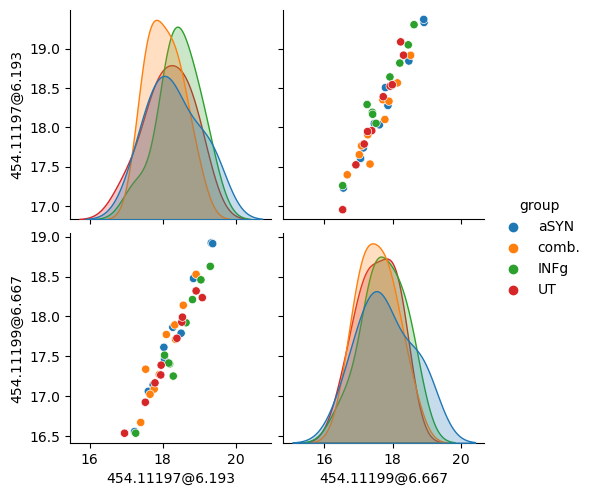

In [34]:
df_test = pd.DataFrame(cluster_test, columns =cluster_masstimes)
df_test['group']=groups.to_numpy(dtype=str)
complete_pairplot(df_test)

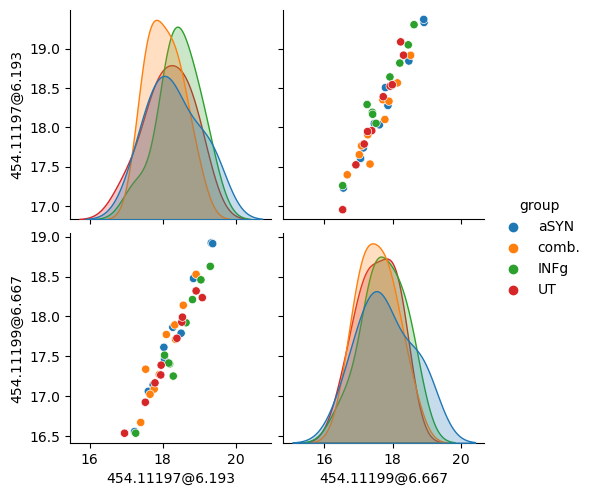

In [35]:
complete_pairplot(df_cluster.iloc[:,-3:], group_col='group', kind='kde', palette=None)

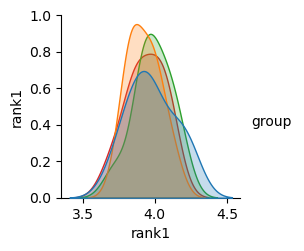

In [36]:
df_test = pd.DataFrame(U, columns =['rank1'])
df_test['group']=groups.to_numpy(dtype=str)
complete_pairplot(df_test)

In [37]:
res=np.linalg.eig(X_test@X_test.T)
u=np.real(res[1][:,0])*np.sqrt(np.real(res[0][0]))
u*=np.sign(u)
u

array([27.05053918, 27.07240309, 24.6693468 , 25.55761864, 24.51752157,
       25.11538213, 26.3894577 , 25.66973215, 23.89612391, 25.20706831,
       26.47752744, 25.36756562, 24.87941237, 25.95625268, 24.65203312,
       25.5060562 , 25.61760912, 24.52504502, 24.09671044, 24.65809313,
       25.14192414, 26.82647612, 25.85829032, 25.17709612, 26.52499249,
       26.18680162, 25.16635891, 23.90413898, 25.1520094 , 25.82524917,
       26.33416277, 25.542278  , 26.39707625, 24.99837356, 24.72200969,
       25.77981311, 24.90510402, 24.36323732, 23.683921  , 25.83593467])

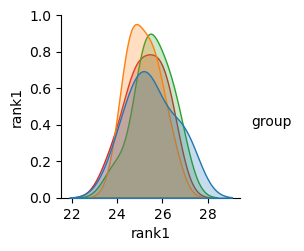

In [38]:
df_u = pd.DataFrame(u, columns =['rank1'])
df_u['group']=groups.to_numpy(dtype=str)
complete_pairplot(df_u)

In [39]:
t_test_(u[:10],u[10:20])

(0.4163356341315574, 0.8343950325341541, 16.009740780494305)

In [40]:
X_test.shape

(40, 2)

In [41]:
t_test(X_test[:10,:],X_test[10:20,:])[0]

array([0.38216577, 0.45426755])

In [42]:
ttest_ind(u[:10],u[10:20], equal_var=False)

TtestResult(statistic=0.8343950325341541, pvalue=0.4163356341315574, df=16.009740780494305)

## Effects

In [52]:
import pystan

In [46]:
group_id = np.ones((20,))
group_id[10:] = 2
group_id

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

In [55]:
data = {        "N": 10,
                "N_g": 2,
                "y": u[:20],
                "group_id":group_id
       }


code = """
data {
  int<lower = 1> N;                              // sample size 
  int<lower = 2> N_g;                            // number of groups
  vector[N] y;                                   // response
  int<lower = 1, upper = N_g> group_id[N];       // group ID
}

transformed data{
  real y_mean;                                   // mean of y; see mu prior
  y_mean = mean(y); 
}

parameters {
  vector[2] mu;                                  // estimated group means and sd
  vector<lower = 0>[2] sigma;                    // Kruschke puts upper bound as well; ignored here
  real<lower = 0, upper = 100> nu;               // df for t distribution
}

model {
  // priors
  // note that there is a faster implementation of this for stan, 
  // and that the sd here is more informative than in Kruschke paper
  mu    ~ normal(y_mean, 10);                       
  sigma ~ cauchy(0, 5);
  
  // Based on Kruschke; makes average nu 29 
  // might consider upper bound, as if too large then might as well switch to normal
  nu    ~ exponential(1.0/29);                
  
  // likelihood
  for (n in 1:N) {
    y[n] ~ student_t(nu, mu[group_id[n]], sigma[group_id[n]]);
    
    // compare to normal; remove all nu specifications if you do this;
    //y[n] ~ normal(mu[group_id[n]], sigma[group_id[n]]);           
  }
}

generated quantities {
  vector[N] y_rep;                               // posterior predictive distribution
  real mu_diff;                                  // mean difference
  real cohens_d;                                 // effect size; see footnote 1 in Kruschke paper
  real CLES;                                     // common language effect size
  real CLES2;                                    // a more explicit approach; the mean should roughly equal CLES

  for (n in 1:N) {
    y_rep[n] = student_t_rng(nu, mu[group_id[n]], sigma[group_id[n]]);
  }

  mu_diff  = mu[1] - mu[2];
  cohens_d = mu_diff / sqrt(sum(sigma)/2);
  CLES     = normal_cdf(mu_diff / sqrt(sum(sigma)), 0, 1);
  CLES2    = student_t_rng(nu, mu[1], sigma[1]) - student_t_rng(nu, mu[2], sigma[2]) > 0;
}

"""

In [56]:
fit = pystan.stan(model_code=code, data=data, iter=1000, chains=1)

CompileError: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2022\\BuildTools\\VC\\Tools\\MSVC\\14.36.32532\\bin\\HostX86\\x64\\cl.exe' failed with exit code 2

In [50]:

posterior = build(code, data=data)
fit = posterior.sample(num_chains=4, num_samples=1000)
#eta = fit["eta"]  # array with shape (8, 4000)
#df = fit.to_frame()  # pandas `DataFrame, requires pandas

NameError: name 'build' is not defined